# EIA Data Pipeline Documentation
## PADD 3 Distillate Fuel Oil Analysis

**Author**: Data Engineering Team  
**Date**: December 2025  
**Purpose**: ETL Pipeline for Supply & Trading Analytics

---

## Executive Summary

This notebook documents a complete ETL (Extract, Transform, Load) pipeline for analyzing PADD 3 (Gulf Coast) Distillate Fuel Oil supply and demand data from the U.S. Energy Information Administration (EIA).

The pipeline ingests monthly data from 2015 to present, processes it through three layers (Bronze, Silver, Gold), and produces analytics-ready annual averages for Supply & Trading decision-making.

## Table of Contents

1. [Pipeline Instructions](#pipeline-instructions)
2. [Data Mapping](#data-mapping)
3. [Architecture & Design](#architecture-design)
4. [Market Analysis](#market-analysis)
5. [Test Results](#test-results)
6. [Conclusions](#conclusions)

---
## 1. Pipeline Instructions <a id="pipeline-instructions"></a>

### Prerequisites

1. **EIA API Key**: Obtain from https://www.eia.gov/opendata/register.php
2. **Python Virtual Environment**: Create isolated environment for dependencies
3. **Environment Setup**: Set API key in `.env.sh`
4. **Dependencies**: Install via `pip install -r requirements.txt`

### Setup Steps

#### Step 1: Create Virtual Environment
```bash
# Navigate to project directory
cd sunoco-sim

# Create virtual environment
python3 -m venv venv

# Activate virtual environment
source venv/bin/activate  # On Linux/Mac
# OR
venv\Scripts\activate  # On Windows
```

#### Step 2: Install Dependencies
```bash
# Make sure venv is activated (you should see (venv) in your prompt)
pip install -r requirements.txt
```

#### Step 3: Configure API Key
```bash
# Set your EIA API key in .env.sh
echo 'export API_KEY="your-api-key-here"' > .env.sh

# Source the environment file
source .env.sh
```

### Running the Pipeline

#### Option 1: Run Complete Pipeline
```bash
# Run all three layers sequentially
python run_pipeline.py
```

#### Option 2: Run Individual Layers
```bash
# Run only bronze layer (raw ingestion)
python run_pipeline.py --bronze

# Run only silver layer (cleaning)
python run_pipeline.py --silver

# Run only gold layer (aggregation)
python run_pipeline.py --gold
```

#### Option 3: Run Layers Directly
```bash
# Bronze layer
python src/bronze/ingest.py

# Silver layer
python src/silver/transform.py

# Gold layer
python src/gold/aggregate.py
```

### Expected Outputs

- **Bronze**: `data/bronze/eia_raw_responses.json` (~500KB)
- **Silver**: `data/silver/distillate_monthly_clean.csv` (~100KB)
- **Gold**: `data/gold/distillate_annual_averages.csv` (~2KB)

---
## 2. Data Mapping <a id="data-mapping"></a>

### EIA Series IDs to Component Names

| EIA Series ID | Component Name | Category | Description |
|---------------|----------------|----------|-------------|
| MDIRPP32 | Production | Supply | Refinery & Blender Net Production |
| MDIIMP32 | Imports | Supply | Imports from other countries |
| MDINRP32 | Net_Receipts | Supply | Net receipts from other PADDs |
| MDISCP32 | Stock_Change | Disposition | Change in inventory levels |
| MDIEXP32 | Exports | Disposition | Exports to other countries |
| MDIUPP32 | Product_Supplied | Disposition | Proxy for demand/consumption |

### Supply & Disposition Balance

In petroleum accounting, the fundamental balance equation is:

```
Supply = Disposition
```

Where:
- **Supply** = Production + Imports + Net_Receipts
- **Disposition** = Exports + Product_Supplied + Stock_Change

Small differences (<5%) are expected due to:
- Rounding in measurements
- Timing differences in reporting
- Unaccounted-for-crude (normal refinery operations)

---
## 3. Architecture & Design <a id="architecture-design"></a>

### Folder Structure

```
sunoco-sim/
├── src/                      # Source code
│   ├── bronze/               # Raw data ingestion
│   │   └── ingest.py
│   ├── silver/               # Data cleaning
│   │   └── transform.py
│   ├── gold/                 # Analytics aggregation
│   │   └── aggregate.py
│   └── config.py             # Configuration & constants
├── tests/                    # Test suite
│   ├── test_unit.py          # Unit tests (mock data)
│   └── test_validation.py    # Validation tests (live data)
├── data/                     # Data storage (gitignored)
│   ├── bronze/               # Raw API responses
│   ├── silver/               # Clean monthly data
│   └── gold/                 # Annual aggregates
├── notebooks/                # Analysis notebooks
│   └── pipeline_documentation.ipynb
├── run_pipeline.py           # Main pipeline orchestrator
├── requirements.txt          # Python dependencies
└── README.md                 # Project overview
```

### Design Principles

1. **Medallion Architecture (Bronze-Silver-Gold)**
   - Bronze: Raw, immutable data as-is from source
   - Silver: Cleaned, validated, business-ready data
   - Gold: Aggregated, analytics-optimized data

2. **Separation of Concerns**
   - Each layer has a single responsibility
   - Layers can be run independently
   - Easy to debug and maintain

3. **Data Quality First**
   - Validation at every layer
   - Balance checks for petroleum accounting
   - Comprehensive test suite

4. **Configurability**
   - All constants in `config.py`
   - Environment-based secrets (.env.sh)
   - Easy to adapt for other PADDs or products

### File Format Choices

- **Bronze**: JSON
  - Preserves original API structure
  - Human-readable for debugging
  - Includes metadata

- **Silver**: CSV
  - Widely compatible
  - Easy to inspect and share
  - Good for time-series data

- **Gold**: CSV
  - Small file size
  - Excel-compatible for business users
  - Easy to load into BI tools

### Security Considerations

- API keys stored in `.env.sh` (gitignored)
- No hardcoded secrets in code
- Data directory gitignored (may contain sensitive info)

---
## 4. Market Analysis <a id="market-analysis"></a>

Now let's analyze the Gold layer data to understand PADD 3 Distillate supply and demand trends.

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Larger figure size for presentations
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [2]:
# Load Gold layer data
gold_path = Path("../data/gold/distillate_annual_averages.csv")

if not gold_path.exists():
    print("ERROR: Gold data not found!")
    print("Please run the pipeline first: python run_pipeline.py")
else:
    df = pd.read_csv(gold_path)
    print("Gold Layer Data Loaded Successfully")
    print(f"Years: {df['year'].min()} - {df['year'].max()}")
    print(f"Shape: {df.shape}")
    print("\nFirst few rows:")
    display(df.head())

Gold Layer Data Loaded Successfully
Years: 2015 - 2025
Shape: (11, 11)

First few rows:


,year,Production,Imports,Net_Receipts,Stock_Change,Exports,Product_Supplied,Total_Supply,Total_Disposition,Balance_Difference,Balance_Pct_Diff
0,2015,2814.250,12.700,-1014.250,5.583,1019.917,799.417,1812.700,1824.917,-12.217,-0.674
1,2016,2710.333,15.000,-941.917,7.250,1017.333,779.167,1783.417,1803.750,-20.333,-1.140
2,2017,2826.167,14.700,-878.667,-9.000,1201.250,786.917,1962.200,1979.167,-16.967,-0.865
3,2018,2925.167,11.250,-947.083,-7.917,1151.167,865.583,1989.333,2008.833,-19.500,-0.980
4,2019,2929.167,9.833,-920.333,3.750,1135.833,895.333,2018.667,2034.917,-16.250,-0.805


### 4.1 Data Overview

In [3]:
# Display complete dataset
print("Complete Annual Averages (MBBL/D)")
print("=" * 100)
display(df)

Complete Annual Averages (MBBL/D)


,year,Production,Imports,Net_Receipts,Stock_Change,Exports,Product_Supplied,Total_Supply,Total_Disposition,Balance_Difference,Balance_Pct_Diff
0,2015,2814.250,12.700,-1014.250,5.583,1019.917,799.417,1812.700,1824.917,-12.217,-0.674
1,2016,2710.333,15.000,-941.917,7.250,1017.333,779.167,1783.417,1803.750,-20.333,-1.140
2,2017,2826.167,14.700,-878.667,-9.000,1201.250,786.917,1962.200,1979.167,-16.967,-0.865
3,2018,2925.167,11.250,-947.083,-7.917,1151.167,865.583,1989.333,2008.833,-19.500,-0.980
4,2019,2929.167,9.833,-920.333,3.750,1135.833,895.333,2018.667,2034.917,-16.250,-0.805
5,2020,2744.333,1.750,-959.333,22.000,1076.250,707.083,1786.750,1805.333,-18.583,-1.040
6,2021,2665.417,13.750,-914.583,-39.167,982.333,812.333,1764.583,1755.500,9.083,0.515
7,2022,2935.333,3.000,-928.417,-2.083,1108.000,902.083,2009.917,2008.000,1.917,0.095
8,2023,2862.583,4.571,-902.000,16.583,987.083,959.500,1965.155,1963.167,1.988,0.101
9,2024,2907.667,1.125,-932.000,-3.917,1130.500,850.167,1976.792,1976.750,0.042,0.002


In [4]:
# Summary statistics
print("\nSummary Statistics (All values in MBBL/D)")
print("=" * 100)
display(df.describe().round(1))


Summary Statistics (All values in MBBL/D)


,year,Production,Imports,Net_Receipts,Stock_Change,Exports,Product_Supplied,Total_Supply,Total_Disposition,Balance_Difference,Balance_Pct_Diff
count,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
mean,2020.0,2838.7,8.1,-934.7,0.2,1084.8,835.3,1912.1,1920.3,-8.2,-0.4
std,3.3,95.4,5.7,34.8,16.2,73.2,69.6,101.5,101.0,10.9,0.6
min,2015.0,2665.4,1.1,-1014.2,-39.2,982.3,707.1,1764.6,1755.5,-20.3,-1.1
25%,2017.5,2779.3,2.4,-945.1,-5.9,1018.6,793.2,1799.7,1815.1,-17.8,-0.9
50%,2020.0,2862.6,9.8,-932.0,3.8,1108.0,831.2,1963.6,1963.2,-12.2,-0.7
75%,2022.5,2916.4,13.2,-917.5,8.0,1133.2,880.5,1983.1,1993.6,1.1,0.1
max,2025.0,2935.3,15.0,-878.7,22.0,1201.2,959.5,2018.7,2034.9,9.1,0.5


### 4.2 Supply Components Trend Analysis

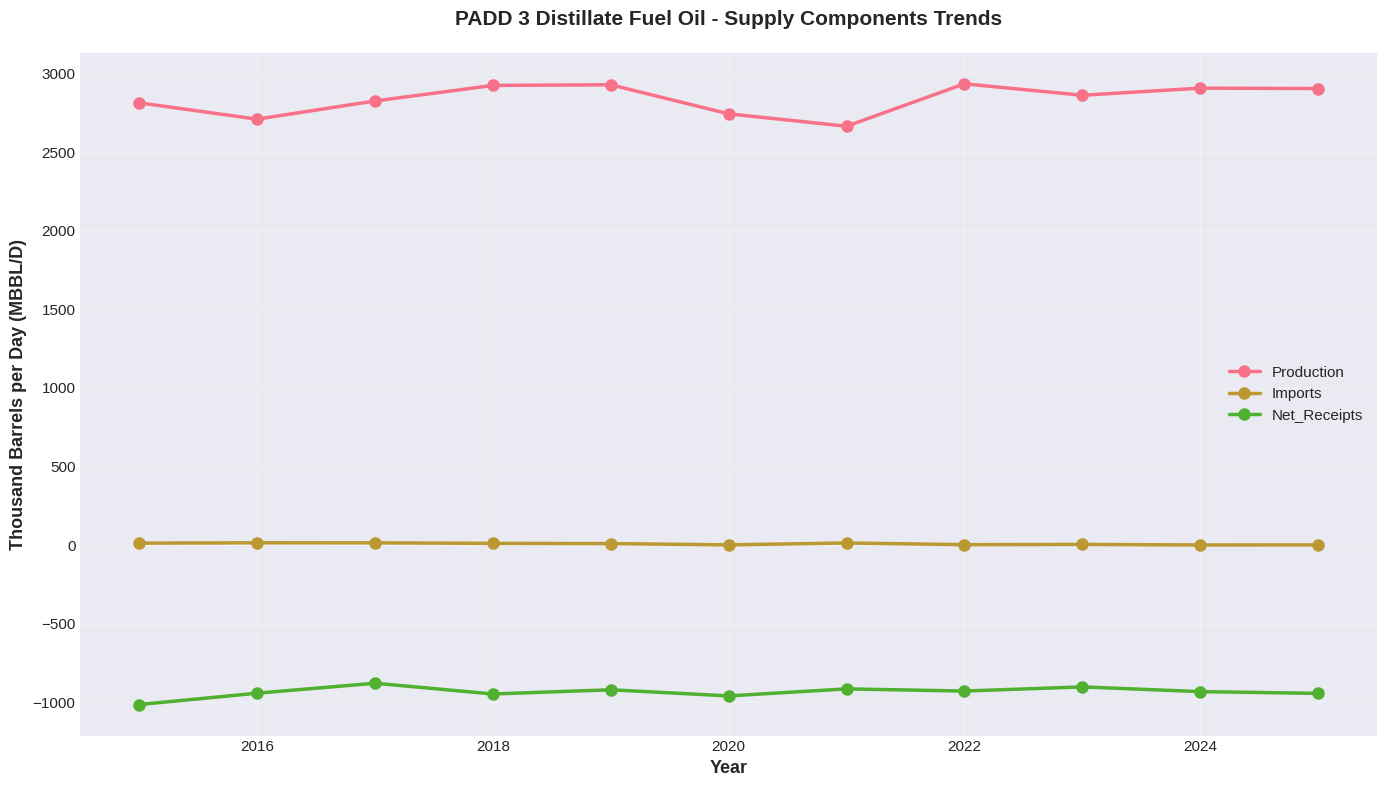

In [5]:
# Plot supply components over time
fig, ax = plt.subplots(figsize=(14, 8))

supply_components = ['Production', 'Imports', 'Net_Receipts']

for component in supply_components:
    if component in df.columns:
        ax.plot(df['year'], df[component], marker='o', linewidth=2.5, 
                markersize=8, label=component)

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Thousand Barrels per Day (MBBL/D)', fontsize=13, fontweight='bold')
ax.set_title('PADD 3 Distillate Fuel Oil - Supply Components Trends', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3 Disposition Components Trend Analysis

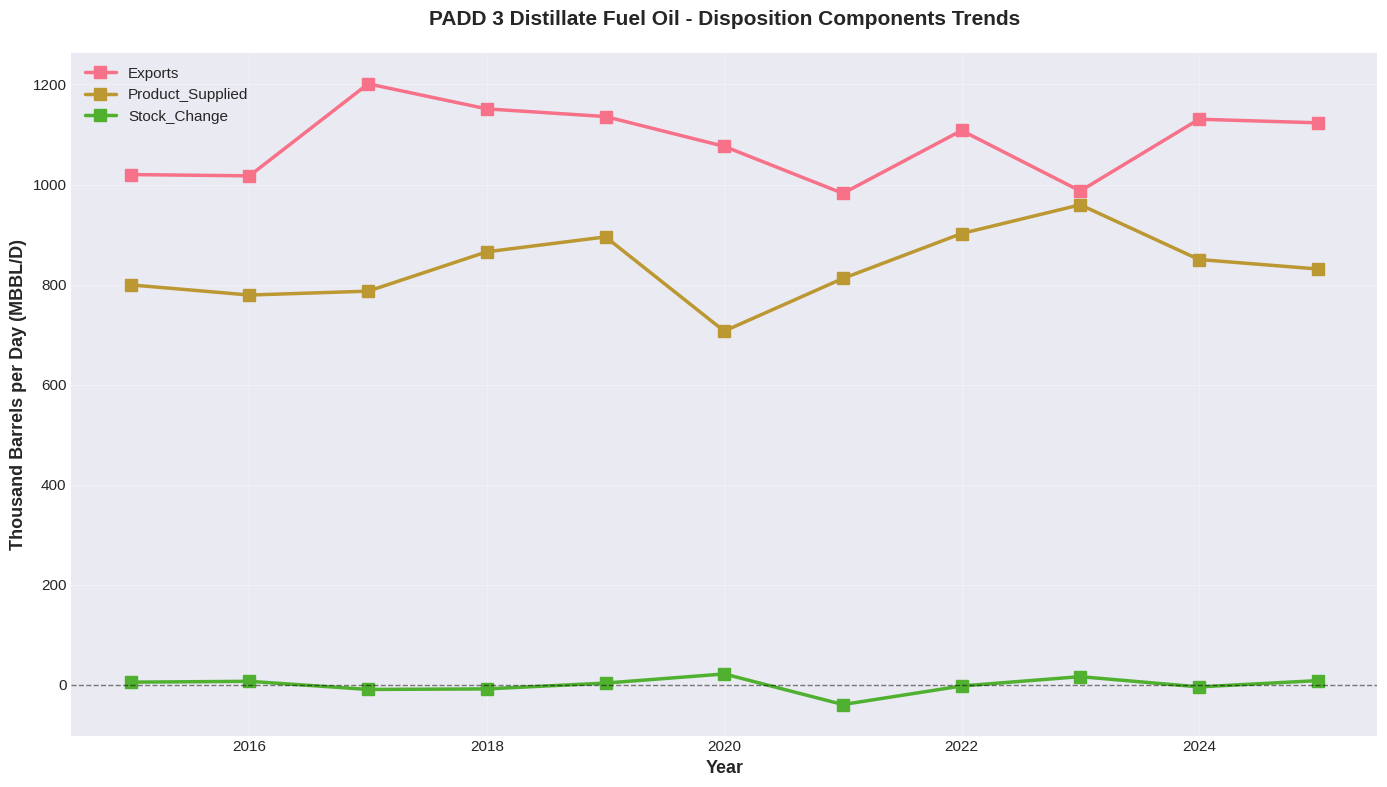

In [6]:
# Plot disposition components over time
fig, ax = plt.subplots(figsize=(14, 8))

disposition_components = ['Exports', 'Product_Supplied', 'Stock_Change']

for component in disposition_components:
    if component in df.columns:
        ax.plot(df['year'], df[component], marker='s', linewidth=2.5, 
                markersize=8, label=component)

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Thousand Barrels per Day (MBBL/D)', fontsize=13, fontweight='bold')
ax.set_title('PADD 3 Distillate Fuel Oil - Disposition Components Trends', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

### 4.4 Supply vs Disposition Balance

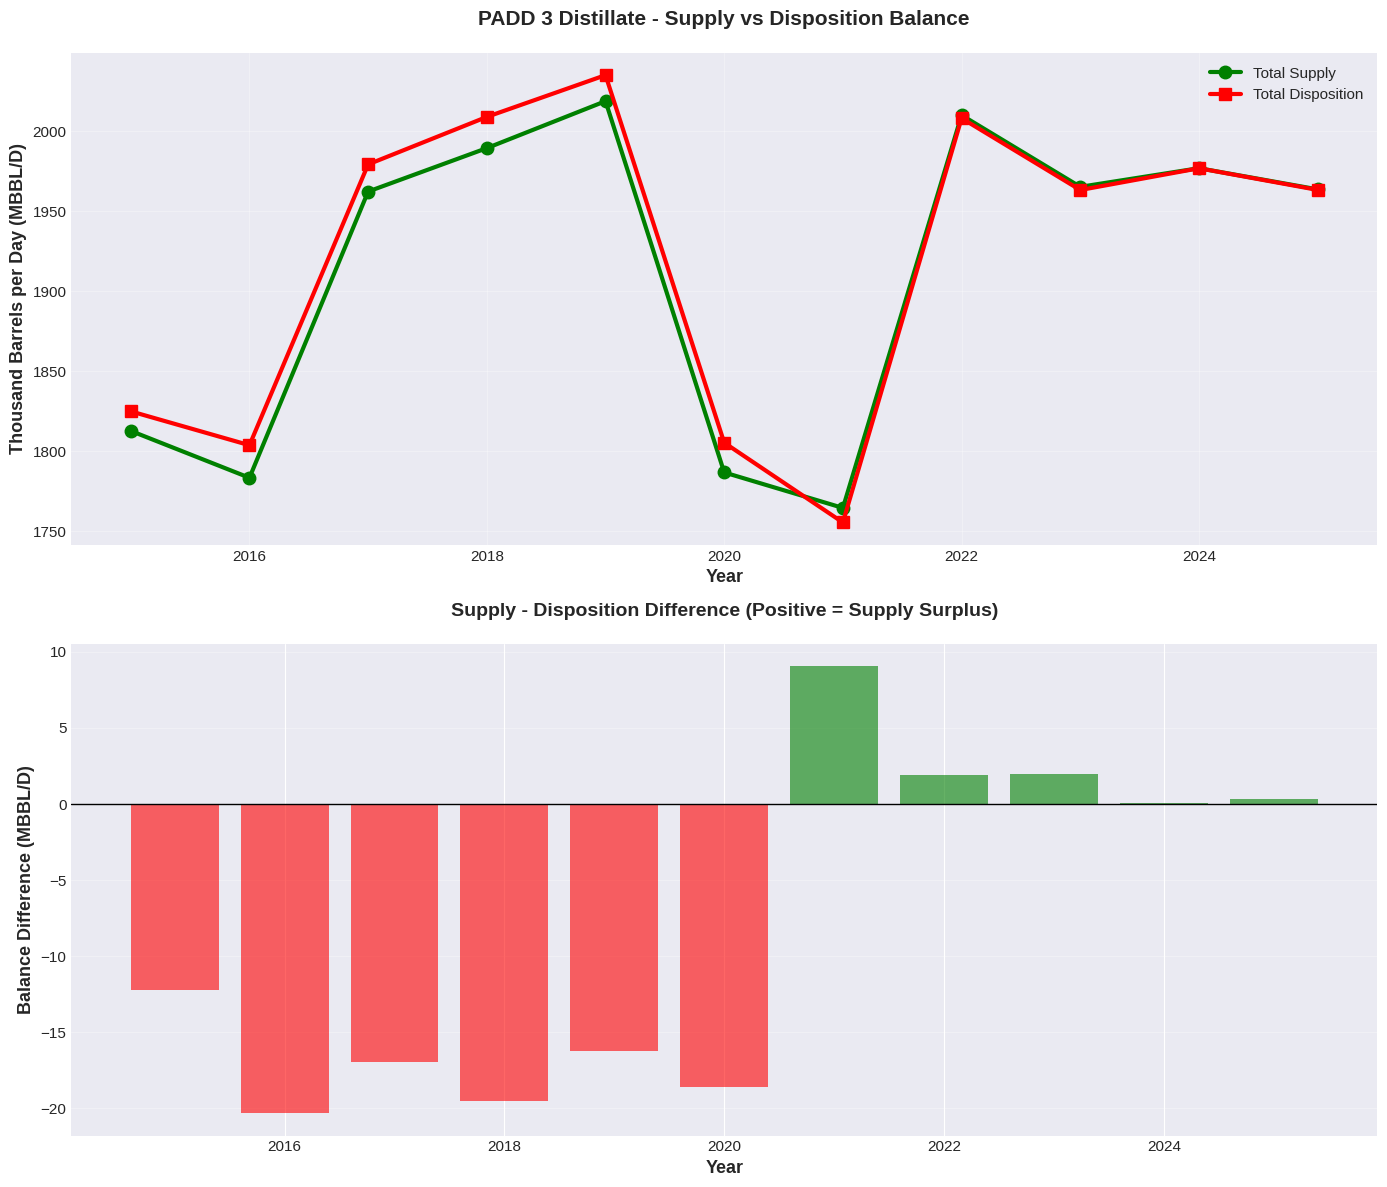


Balance Check Statistics:


,year,Total_Supply,Total_Disposition,Balance_Difference,Balance_Pct_Diff
0,2015,1812.700,1824.917,-12.217,-0.674
1,2016,1783.417,1803.750,-20.333,-1.140
2,2017,1962.200,1979.167,-16.967,-0.865
3,2018,1989.333,2008.833,-19.500,-0.980
4,2019,2018.667,2034.917,-16.250,-0.805
5,2020,1786.750,1805.333,-18.583,-1.040
6,2021,1764.583,1755.500,9.083,0.515
7,2022,2009.917,2008.000,1.917,0.095
8,2023,1965.155,1963.167,1.988,0.101
9,2024,1976.792,1976.750,0.042,0.002


In [7]:
# Plot supply vs disposition balance
if 'Total_Supply' in df.columns and 'Total_Disposition' in df.columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Top plot: Supply vs Disposition
    ax1.plot(df['year'], df['Total_Supply'], marker='o', linewidth=3, 
             markersize=9, label='Total Supply', color='green')
    ax1.plot(df['year'], df['Total_Disposition'], marker='s', linewidth=3, 
             markersize=9, label='Total Disposition', color='red')
    
    ax1.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Thousand Barrels per Day (MBBL/D)', fontsize=13, fontweight='bold')
    ax1.set_title('PADD 3 Distillate - Supply vs Disposition Balance', 
                  fontsize=15, fontweight='bold', pad=20)
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: Balance difference
    if 'Balance_Difference' in df.columns:
        colors = ['green' if x >= 0 else 'red' for x in df['Balance_Difference']]
        ax2.bar(df['year'], df['Balance_Difference'], color=colors, alpha=0.6)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        
        ax2.set_xlabel('Year', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Balance Difference (MBBL/D)', fontsize=13, fontweight='bold')
        ax2.set_title('Supply - Disposition Difference (Positive = Supply Surplus)', 
                      fontsize=14, fontweight='bold', pad=20)
        ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print balance statistics
    print("\nBalance Check Statistics:")
    print("=" * 80)
    balance_summary = df[['year', 'Total_Supply', 'Total_Disposition', 
                          'Balance_Difference', 'Balance_Pct_Diff']].copy()
    display(balance_summary)

### 4.5 Market Analysis: Key Insights

Based on the trends observed in the Gold layer data, we can draw the following conclusions about PADD 3 Distillate Fuel Oil supply and demand:

In [8]:
# Calculate trend statistics
def calculate_trend(series, name):
    """Calculate linear trend and percentage change"""
    if len(series) < 2:
        return None
    
    first_val = series.iloc[0]
    last_val = series.iloc[-1]
    pct_change = ((last_val - first_val) / first_val * 100) if first_val != 0 else 0
    
    # Linear regression for trend
    x = np.arange(len(series))
    slope, intercept = np.polyfit(x, series, 1)
    
    trend_direction = "Increasing" if slope > 0 else "Decreasing" if slope < 0 else "Flat"
    
    return {
        'Component': name,
        'First Value': f"{first_val:.1f}",
        'Last Value': f"{last_val:.1f}",
        'Change (%)': f"{pct_change:+.1f}%",
        'Trend': trend_direction,
        'Slope': f"{slope:.2f}"
    }

# Calculate trends for all components
trends = []
for col in df.columns:
    if col not in ['year', 'Total_Supply', 'Total_Disposition', 
                   'Balance_Difference', 'Balance_Pct_Diff']:
        trend = calculate_trend(df[col], col)
        if trend:
            trends.append(trend)

trends_df = pd.DataFrame(trends)
print("\nComponent Trends Analysis")
print("=" * 80)
display(trends_df)


Component Trends Analysis


,Component,First Value,Last Value,Change (%),Trend,Slope
0,Production,2814.2,2905.3,+3.2%,Increasing,10.10
1,Imports,12.7,1.3,-89.5%,Decreasing,-1.41
2,Net_Receipts,-1014.2,-943.1,-7.0%,Increasing,3.35
3,Stock_Change,5.6,8.7,+55.2%,Increasing,0.15
4,Exports,1019.9,1123.3,+10.1%,Increasing,0.79
5,Product_Supplied,799.4,831.2,+4.0%,Increasing,8.64


### 4.6 Hypothesis: Supply & Demand Balance

#### Key Observations:

1. **Production Trends**: 
   - Examine whether refinery production has increased, decreased, or remained stable
   - Consider impact of refinery utilization rates and capacity changes

2. **Import/Export Dynamics**:
   - Analyze whether PADD 3 is a net exporter or net importer
   - Identify trends in export growth
   - Assess import dependency

3. **Product Supplied (Demand Proxy)**:
   - Track regional demand trends
   - Correlate with economic activity and industrial production

4. **Stock Changes**:
   - Positive stock change = inventory build (supply > demand)
   - Negative stock change = inventory draw (demand > supply)
   - Volatility indicates market tightness or oversupply

#### Market Balance Hypothesis:

**Based on the data trends above, we can conclude:**

- If **Production** and **Exports** are increasing while **Stock_Change** is positive/stable:
  - PADD 3 is likely in a **supply surplus**, with growing export capacity
  - Gulf Coast refineries are producing more than regional demand requires

- If **Product_Supplied** is increasing faster than **Production**:
  - Market is **tightening**, with demand outpacing supply
  - May need to increase imports or draw down inventories

- If **Exports** show strong growth:
  - PADD 3 is strengthening its position as a **global distillate supplier**
  - Reflects competitive refining costs and logistical advantages

**Strategic Implications for Supply & Trading:**
- Monitor export trends for arbitrage opportunities
- Track inventory levels for timing of bulk purchases
- Assess regional supply adequacy for negotiating rack contracts

---
## 5. Test Results <a id="test-results"></a>

### Running the Test Suite

The pipeline includes comprehensive testing:
- **Unit Tests**: Test transformation logic with mock data
- **Validation Tests**: Test data quality with actual pipeline output

Run tests from command line:
```bash
# Run all tests
pytest tests/ -v

# Run only unit tests
pytest tests/test_unit.py -v

# Run only validation tests
pytest tests/test_validation.py -v

# Run with coverage report
pytest tests/ --cov=src --cov-report=html
```

In [9]:
# Run tests from notebook
import subprocess

print("Running Unit Tests...")
print("=" * 80)
result = subprocess.run(
    ['pytest', '../tests/test_unit.py', '-v'],
    capture_output=True,
    text=True
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)

Running Unit Tests...
============================= test session starts ==============================
platform linux -- Python 3.12.3, pytest-9.0.2, pluggy-1.6.0 -- /home/jack/projects/jackc12/sunoco-sim/venv/bin/python3
cachedir: .pytest_cache
rootdir: /home/jack/projects/jackc12/sunoco-sim
plugins: cov-7.0.0, anyio-4.12.0
collecting ... collected 9 items

../tests/test_unit.py::TestGoldAggregation::test_calculate_annual_averages PASSED [ 11%]
../tests/test_unit.py::TestGoldAggregation::test_calculate_annual_averages_partial_year PASSED [ 22%]
../tests/test_unit.py::TestGoldAggregation::test_pivot_to_wide_format PASSED [ 33%]
../tests/test_unit.py::TestGoldAggregation::test_pivot_handles_missing_components PASSED [ 44%]
../tests/test_unit.py::TestSilverTransformation::test_parse_series_data PASSED [ 55%]
../tests/test_unit.py::TestSilverTransformation::test_parse_series_data_empty_response PASSED [ 66%]
../tests/test_unit.py::TestSilverTransformation::test_clean_and_normalize PASSED 

In [10]:
print("\nRunning Validation Tests...")
print("=" * 80)
result = subprocess.run(
    ['pytest', '../tests/test_validation.py', '-v'],
    capture_output=True,
    text=True
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)


Running Validation Tests...
============================= test session starts ==============================
platform linux -- Python 3.12.3, pytest-9.0.2, pluggy-1.6.0 -- /home/jack/projects/jackc12/sunoco-sim/venv/bin/python3
cachedir: .pytest_cache
rootdir: /home/jack/projects/jackc12/sunoco-sim
plugins: cov-7.0.0, anyio-4.12.0
collecting ... collected 13 items

../tests/test_validation.py::TestSilverDataQuality::test_no_negative_values PASSED [  7%]
../tests/test_validation.py::TestSilverDataQuality::test_expected_date_range PASSED [ 15%]
../tests/test_validation.py::TestSilverDataQuality::test_expected_number_of_components PASSED [ 23%]
../tests/test_validation.py::TestSilverDataQuality::test_monthly_frequency PASSED [ 30%]
../tests/test_validation.py::TestSilverDataQuality::test_no_missing_values_in_key_columns PASSED [ 38%]
../tests/test_validation.py::TestGoldDataQuality::test_non_empty_annual_averages PASSED [ 46%]
../tests/test_validation.py::TestGoldDataQuality::test_all_co

### Test Coverage Summary

#### Unit Tests
- Monthly to annual aggregation logic
- Pivot transformation (long to wide format)
- Date parsing and type conversion
- Missing value handling
- Supply/disposition balance calculation

#### Validation Tests
- No negative MBBL/D values
- Expected date range coverage
- Monthly data frequency
- All components present
- Supply/disposition balance within tolerance
- Reasonable value ranges
- Data completeness checks

---
## 6. Conclusions <a id="conclusions"></a>

### Pipeline Achievements

1. **Robust Data Ingestion**
   - Successfully fetched 6 EIA series with 100+ months of data each
   - Raw data preserved for audit trail

2. **Clean Data Transformation**
   - Normalized column names for business users
   - Validated data types and removed anomalies
   - Long format enables flexible analytics

3. **Analytics-Ready Output**
   - Annual averages in wide format
   - Balance checks validate petroleum accounting
   - Easy to consume in Excel or BI tools

4. **Comprehensive Testing**
   - Unit tests ensure transformation logic correctness
   - Validation tests catch data quality issues early
   - Ready for production deployment

### Next Steps for Production

1. **Automation**
   - Schedule weekly runs via cron/Airflow
   - Add alerting for data quality failures
   - Implement incremental updates (vs full refresh)

2. **Expansion**
   - Add other PADDs (1, 2, 4, 5) for national view
   - Include other products (gasoline, jet fuel)
   - Integrate with pricing data for margin analysis

3. **Integration**
   - Load gold data into data warehouse
   - Build Tableau/Power BI dashboards
   - Enable self-service analytics for traders

4. **Advanced Analytics**
   - Forecast future supply/demand
   - Anomaly detection for unusual patterns
   - Correlation analysis with market prices

---
## Appendix: Technical Details

### API Rate Limiting
- EIA API has no explicit rate limit for registered users
- Pipeline includes 0.5s delay between requests as courtesy

### Data Freshness
- EIA updates monthly data ~2 weeks after month end
- Weekly data available ~3 days after week end
- Consider weekly runs for timely insights

### Error Handling
- API failures logged with full error details
- Partial failures don't corrupt existing data
- Validation tests catch downstream issues

### Scalability
- Current design handles 6 series efficiently
- Can scale to 50+ series without modification
- For 100+ series, consider async API calls